In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation,BatchNormalization,Input,Embedding,Dot,Dense,Flatten
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler,TensorBoard,EarlyStopping
from wordcloud import WordCloud
%matplotlib inline

### READING ANIMELIST.CSV 

In [2]:
import os

In [3]:
INPUT_DIR = os.path.join("..","artifacts","raw")

In [4]:
rating_df = pd.read_csv(INPUT_DIR+"/animelist.csv", low_memory=True,usecols=["user_id","anime_id","rating"])

In [5]:
rating_df.head()

,user_id,anime_id,rating
0,0,67,9
1,0,6702,7
2,0,242,10
3,0,4898,0
4,0,21,10


In [6]:
len(rating_df)

5000000

#### DATA PROCESSING

In [7]:
n_ratings = rating_df["user_id"].value_counts()
rating_df = rating_df[rating_df["user_id"].isin(n_ratings[n_ratings >= 400].index)].copy()

In [8]:
len(rating_df)

3246641

In [9]:
min_rating = min(rating_df["rating"])

In [10]:
max_rating = max(rating_df["rating"])

In [11]:
avg_rating = np.mean(rating_df["rating"])

In [12]:
rating_df["rating"] = rating_df["rating"].apply(lambda x: (x-min_rating)/(max_rating-min_rating)).values.astype(np.float64)

In [13]:
avg_rating

np.float64(4.122732695114736)

In [14]:
rating_df.duplicated().sum()

np.int64(0)

In [15]:
rating_df.isnull().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

In [16]:
user_ids = rating_df["user_id"].unique().tolist()
user2user_encoded = {x : i for i , x in enumerate(user_ids)}
user2user_decoded = {i : x for i , x in enumerate(user_ids)}
rating_df["user"] = rating_df["user_id"].map(user2user_encoded)


In [17]:
n_users = len(user2user_encoded)

In [18]:
n_users

4203

In [19]:
anime_ids = rating_df["anime_id"].unique().tolist()
anime2anime_encoded = {x : i for i , x in enumerate(anime_ids)}
anime2anime_decoded = {i : x for i , x in enumerate(anime_ids)}
rating_df["anime"] = rating_df["anime_id"].map(anime2anime_encoded)

In [20]:
n_anime = len(anime2anime_encoded)

In [21]:
n_anime

17149

In [22]:
rating_df = rating_df.sample(frac=1,random_state=42).reset_index(drop=True)

In [23]:
X = rating_df[["user","anime"]].values
y = rating_df["rating"]

In [24]:
test_size = 1000
train_indices = rating_df.shape[0] - test_size

In [25]:
X_train , X_test, y_train, y_test = (
    X[:train_indices],
    X[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

In [26]:
len(X_train)

3245641

In [27]:
len(X_test)

1000

In [28]:
type(X_train)

numpy.ndarray

In [29]:
X_train_array = [X_train[:, 0] , X_train[:, 1]]
X_test_array = [X_test[:, 0] , X_test[:, 1]]


In [30]:
type(X_train_array)

list

In [31]:
type(X_test_array[0])

numpy.ndarray

### MODEL ARCHITECTURE

In [32]:
def RecommenderNet():
    embedding_size=128

    user = Input(name="user",shape=[1])

    user_embedding = Embedding(name="user_embedding", input_dim=n_users, output_dim=embedding_size)(user)

    anime = Input(name="anime",shape=[1])

    anime_embedding = Embedding(name="anime_embedding", input_dim=n_anime, output_dim=embedding_size)(anime)

    x = Dot(name="dot_product", normalize=True, axes=2)([user_embedding,anime_embedding])

    x = Flatten()(x)

    x = Dense(1, kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation("sigmoid")(x)

    model = Model(inputs=[user,anime], outputs=x)
    model.compile(loss="binary_crossentropy",metrics=["mae","mse"],optimizer='Adam')
    return model

In [33]:
model = RecommenderNet()

In [34]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 128)    │    537,984 │ user[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime_embedding     │ (None, 1, 128)    │  2,195,072 │ anime[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_product (Dot)   │ (None, 1, 1)      │          0 │ user_embedding[0… │
│                     │                   │            │ anime_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1)         │          0 │ dot_product[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │          2 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1)         │          4 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 1)         │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,733,062 (10.43 MB)

 Trainable params: 2,733,060 (10.43 MB)

 Non-trainable params: 2 (8.00 B)

In [35]:
start_lr = 0.00001
min_lr = 0.0001
max_lr = 0.00005
batch_size = 10000

ramup_epochs = 5
sustain_epochs = 0
exp_decay = 0.8

def lrfn(epoch):
    if epoch<ramup_epochs:
        return (max_lr-start_lr)/ramup_epochs*epoch + start_lr
    elif epoch<ramup_epochs+sustain_epochs:
        return max_lr
    else:
        return (max_lr-min_lr) * exp_decay ** (epoch-ramup_epochs-sustain_epochs)+min_lr

In [36]:
lr_callback = LearningRateScheduler(lambda epoch:lrfn(epoch) , verbose=0)
checkpoint_filepath = './weights.weights.h5'

model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath,save_weights_only=True,monitor="val_loss",mode="min",save_best_only=True)

early_stopping = EarlyStopping(patience=3, monitor="val_loss",mode="min",restore_best_weights=True)

In [37]:
my_callbacks = [model_checkpoint,lr_callback,early_stopping]

In [38]:
history = model.fit(
    x=X_train_array,
    y=y_train,
    batch_size=batch_size,
    epochs=20,
    verbose=1,
    validation_data = (X_test_array,y_test),
    callbacks=my_callbacks
)

Epoch 1/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 19s 53ms/step - loss: 0.7773 - mae: 0.3779 - mse: 0.1898 - val_loss: 0.7029 - val_mae: 0.3665 - val_mse: 0.1617 - learning_rate: 1.0000e-05
Epoch 2/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 17s 51ms/step - loss: 0.7740 - mae: 0.3767 - mse: 0.1884 - val_loss: 0.7615 - val_mae: 0.3786 - val_mse: 0.1857 - learning_rate: 1.8000e-05
Epoch 3/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 16s 48ms/step - loss: 0.7684 - mae: 0.3746 - mse: 0.1862 - val_loss: 0.7820 - val_mae: 0.3820 - val_mse: 0.1927 - learning_rate: 2.6000e-05
Epoch 4/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 16s 49ms/step - loss: 0.7608 - mae: 0.3718 - mse: 0.1831 - val_loss: 0.7782 - val_mae: 0.3810 - val_mse: 0.1911 - learning_rate: 3.4000e-05


In [39]:
model.load_weights(checkpoint_filepath)

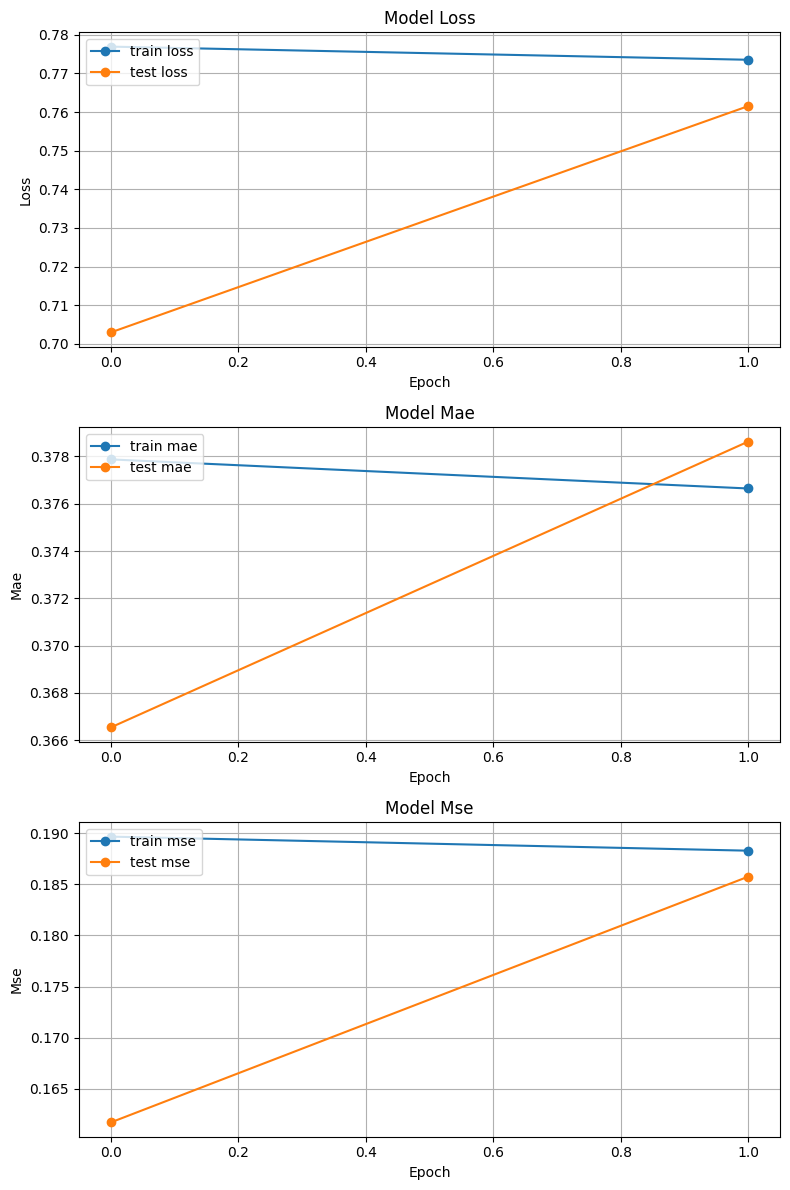

In [40]:
metrics = ["loss", "mae", "mse"]

# Create subplots
fig, axes = plt.subplots(len(metrics), 1, figsize=(8, len(metrics) * 4))

for i, metric in enumerate(metrics):
    ax = axes[i]
    ax.plot(history.history[metric][0:-2], marker="o", label=f"train {metric}")
    ax.plot(history.history[f"val_{metric}"][0:-2], marker="o", label=f"test {metric}")
    ax.set_title(f"Model {metric.capitalize()}")
    ax.set_ylabel(metric.capitalize())
    ax.set_xlabel("Epoch")
    ax.legend(loc="upper left")
    ax.grid(True)

plt.tight_layout()
plt.show()

In [41]:
def extract_weights(name,model, epsilon=1e-10):
    weight_layer = model.get_layer(name)
    weights = weight_layer.get_weights()[0]
    weights = weights/(np.linalg.norm(weights,axis=1)+epsilon).reshape((-1,1))
    return weights

In [42]:
anime_weights = extract_weights("anime_embedding",model)

In [43]:
user_weights = extract_weights("user_embedding",model)

### READING ANIME.CSV

In [44]:
df = pd.read_csv(INPUT_DIR+"/anime.csv",low_memory=True)
df.head(2)

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0


In [45]:
df = df.replace("Unknown",np.nan)

In [46]:
def getAnimeName(anime_id):
    try:
        name = df[df.anime_id == anime_id].eng_version.values[0]
        if name is np.nan:
            name = df[df.anime_id == anime_id].Name.values[0]
    except:
        print("Error")
    return name

In [47]:
df["anime_id"] = df["MAL_ID"]
df["eng_version"] = df["English name"]
df["eng_version"] = df.anime_id.apply(lambda x:getAnimeName(x))

In [48]:
df.head(1)

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,anime_id,eng_version
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0,1,Cowboy Bebop


In [49]:
getAnimeName(6702)

'Fairy Tail'

In [50]:
df.sort_values(by=["Score"],
               inplace=True,
               ascending = False,
               kind="quicksort",
               na_position="last")

In [51]:
df = df[["anime_id","eng_version","Score","Genres","Episodes","Type","Premiered","Members"]]

In [52]:
df.head()

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
3971,5114,Fullmetal Alchemist:Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Ma...",64,TV,Spring 2009,2248456
15926,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",16,TV,Winter 2021,733260
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",24,TV,Spring 2011,1771162
14963,38524,Attack on Titan Season 3 Part 2,9.1,"Action, Drama, Fantasy, Military, Mystery, Sho...",10,TV,Spring 2019,1073626
9913,28977,Gintama Season 4,9.1,"Action, Comedy, Historical, Parody, Samurai, S...",51,TV,Spring 2015,404121


In [53]:
def getAnimeFrame(anime,df):
    if isinstance(anime,int):
        return df[df.anime_id == anime]
    if isinstance(anime,str):
        return df[df.eng_version == anime]

In [54]:
getAnimeFrame(40028,df)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
15926,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",16,TV,Winter 2021,733260


In [55]:
getAnimeFrame('Steins;Gate',df)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",24,TV,Spring 2011,1771162


### ANIME_WITH_SYNOPSIS.CSV

In [56]:
cols = ["MAL_ID","Name","Genres","sypnopsis"]

In [57]:
synopsis_df = pd.read_csv(INPUT_DIR+"/anime_with_synopsis.csv",usecols=cols)

In [58]:
synopsis_df.head(1)

,MAL_ID,Name,Genres,sypnopsis
0,1,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized sever..."


In [59]:
def getSynopsis(anime,synopsis_df):
    if isinstance(anime,int):
        return synopsis_df[synopsis_df.MAL_ID == anime].sypnopsis.values[0]
    if isinstance(anime,str):
        return synopsis_df[synopsis_df.Name == anime].sypnopsis.values[0]

In [60]:
getSynopsis(9253,synopsis_df)

'The self-proclaimed mad scientist Rintarou Okabe rents out a room in a rickety old building in Akihabara, where he indulges himself in his hobby of inventing prospective "future gadgets" with fellow lab members: Mayuri Shiina, his air-headed childhood friend, and Hashida Itaru, a perverted hacker nicknamed "Daru." The three pass the time by tinkering with their most promising contraption yet, a machine dubbed the "Phone Microwave," which performs the strange function of morphing bananas into piles of green gel. Though miraculous in itself, the phenomenon doesn\'t provide anything concrete in Okabe\'s search for a scientific breakthrough; that is, until the lab members are spurred into action by a string of mysterious happenings before stumbling upon an unexpected success—the Phone Microwave can send emails to the past, altering the flow of history. Adapted from the critically acclaimed visual novel by 5pb. and Nitroplus, Steins;Gate takes Okabe through the depths of scientific theory 

In [61]:
getSynopsis("Steins;Gate",synopsis_df)

'The self-proclaimed mad scientist Rintarou Okabe rents out a room in a rickety old building in Akihabara, where he indulges himself in his hobby of inventing prospective "future gadgets" with fellow lab members: Mayuri Shiina, his air-headed childhood friend, and Hashida Itaru, a perverted hacker nicknamed "Daru." The three pass the time by tinkering with their most promising contraption yet, a machine dubbed the "Phone Microwave," which performs the strange function of morphing bananas into piles of green gel. Though miraculous in itself, the phenomenon doesn\'t provide anything concrete in Okabe\'s search for a scientific breakthrough; that is, until the lab members are spurred into action by a string of mysterious happenings before stumbling upon an unexpected success—the Phone Microwave can send emails to the past, altering the flow of history. Adapted from the critically acclaimed visual novel by 5pb. and Nitroplus, Steins;Gate takes Okabe through the depths of scientific theory 

### CONTENT BASED RECOMMENDATION

In [62]:
pd.set_option("max_colwidth",None)

In [63]:
def find_similar_animes(name, anime_weights, anime2anime_encoded, anime2anime_decoded, df, synopsis_df, n=10, return_dist=False, neg=False):
    # Get the anime_id for the given name
    index = getAnimeFrame(name, df).anime_id.values[0]
    encoded_index = anime2anime_encoded.get(index)

    if encoded_index is None:
        raise ValueError(f"Encoded index not found for anime ID: {index}")

    weights = anime_weights

    # Compute the similarity distances
    dists = np.dot(weights, weights[encoded_index])  # Ensure weights[encoded_index] is a 1D array
    sorted_dists = np.argsort(dists)

    n = n + 1

    # Select closest or farthest based on 'neg' flag
    if neg:
        closest = sorted_dists[:n]
    else:
        closest = sorted_dists[-n:]

    # Return distances and closest indices if requested
    if return_dist:
        return dists, closest

    # Build the similarity array
    SimilarityArr = []
    for close in closest:
        decoded_id = anime2anime_decoded.get(close)
       

       
        anime_frame = getAnimeFrame(decoded_id, df)

        anime_name = anime_frame.eng_version.values[0]
        genre = anime_frame.Genres.values[0]
        similarity = dists[close]
   

        SimilarityArr.append({
            "anime_id": decoded_id,
            "name": anime_name,
            "similarity": similarity,
            "genre": genre,
        })
       

    # Create a DataFrame with results and sort by similarity
    Frame = pd.DataFrame(SimilarityArr).sort_values(by="similarity", ascending=False)
    return Frame[Frame.anime_id != index].drop(['anime_id'], axis=1)


In [64]:
find_similar_animes(
    "Steins;Gate",
    anime_weights,
    anime2anime_encoded,
    anime2anime_decoded,
    df,
    synopsis_df
    
)

,name,similarity,genre
9,Bakugan:New Vestroia,0.337346,"Game, Adventure, Fantasy, Shounen"
8,Amazing Nuts!,0.327325,"Adventure, Police, Romance, Music, Sci-Fi"
7,Pokémon the Movie:Secrets of the Jungle,0.308577,"Action, Game, Adventure, Comedy, Kids, Fantasy"
6,Brave Witches,0.304605,"Action, Ecchi, Magic, Military, Sci-Fi"
5,Otome Juurin Yuugi: Maiden Infringement Play,0.299834,Hentai
4,Magical Project S Specials,0.299185,"Adventure, Comedy, Fantasy, Magic, Parody, Seinen"
3,SF Saiyuuki Starzinger (Movie),0.297006,"Adventure, Mecha, Sci-Fi, Shounen"
2,Drawing!!,0.296254,"Dementia, Music"
1,Ninja Scroll:The Series,0.287227,"Adventure, Horror, Magic, Martial Arts, Samurai, Shounen, Supernatural"
0,Swing Out Sisters (2014),0.287163,Hentai


### USER BASED RECOMMENDATION

In [65]:
def find_similar_users(item_input , user_weights , user2user_encoded , user2user_decoded, n=10 , return_dist=False,neg=False):
    try:
        index=item_input
        encoded_index = user2user_encoded.get(index)

        weights = user_weights

        dists = np.dot(weights,weights[encoded_index])
        sorted_dists = np.argsort(dists)

        n=n+1

        if neg:
            closest = sorted_dists[:n]
        else:
            closest = sorted_dists[-n:]
            

        if return_dist:
            return dists,closest
        
        SimilarityArr = []

        for close in closest:
            similarity = dists[close]

            if isinstance(item_input,int):
                decoded_id = user2user_decoded.get(close)
                SimilarityArr.append({
                    "similar_users" : decoded_id,
                    "similarity" : similarity
                })
        similar_users = pd.DataFrame(SimilarityArr).sort_values(by="similarity",ascending=False)
        similar_users = similar_users[similar_users.similar_users != item_input]
        return similar_users
    except Exception as e:
        print("Error Occured",e)

        
        

In [66]:
find_similar_users(int(11880),user_weights,user2user_encoded,user2user_decoded)

,similar_users,similarity
9,10711,0.335127
8,3123,0.296884
7,4762,0.276156
6,7308,0.259404
5,3284,0.255371
4,6531,0.250140
3,4798,0.247394
2,13485,0.243289
1,14526,0.242686
0,1453,0.240630


In [67]:
def showWordCloud(all_genres):
    genres_cloud = WordCloud(width=700,height=400,background_color='white',colormap='gnuplot').generate_from_frequencies(all_genres)
    plt.figure(figsize=(10,8))
    plt.imshow(genres_cloud,interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [68]:
from collections import defaultdict

In [69]:
def getFavGenre(frame, plot=False):
    frame.dropna(inplace=False)
    all_genres = defaultdict(int)

    genres_list = []
    for genres in frame["Genres"]:
        if isinstance(genres,str):
            for genre in genres.split(','):
                genres_list.append(genre)
                all_genres[genre.strip()] +=1

    if plot:
        showWordCloud(all_genres)

    return genres_list

In [70]:
def get_user_preferences(user_id, rating_df, verbose=0, plot=False):
    animes_watched_by_user = rating_df[rating_df.user_id == user_id]
    
    user_rating_percentile = np.percentile(animes_watched_by_user.rating , 75)

    animes_watched_by_user = animes_watched_by_user[animes_watched_by_user.rating >= user_rating_percentile]

    top_anime_user = (
        animes_watched_by_user.sort_values(by="rating", ascending=False).anime_id.values
    )

    anime_df_rows = df[df["anime_id"].isin(top_anime_user)]
    anime_df_rows = anime_df_rows[["eng_version","Genres"]]

    if plot:
        getFavGenre(anime_df_rows,plot)

    return anime_df_rows

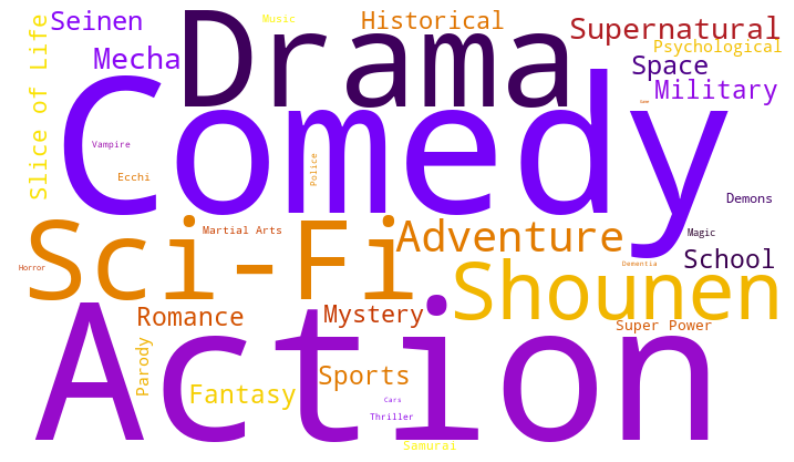

,eng_version,Genres
3971,Fullmetal Alchemist:Brotherhood,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen"
9913,Gintama Season 4,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen"
6474,Hunter x Hunter,"Action, Adventure, Fantasy, Shounen, Super Power"
6006,Gintama Season 2,"Action, Sci-Fi, Comedy, Historical, Parody, Samurai, Shounen"
741,Legend of the Galactic Heroes,"Military, Sci-Fi, Space, Drama"
...,...,...
2575,Shootfighter Tekken,"Action, Martial Arts, Shounen"
8064,Samurai Flamenco,"Action, Comedy, Parody, Super Power"
510,Venus Wars,"Action, Sci-Fi, Adventure, Space"
6864,Saint Seiya Omega,"Action, Adventure, Fantasy, Shounen"


In [71]:
get_user_preferences(11880, rating_df, df, plot=True)

In [89]:
def get_user_recommendations(similar_users , user_pref ,df , synopsis_df, rating_df, n=10):

    recommended_animes = []
    anime_list = []

    for user_id in similar_users.similar_users.values:
        pref_list = get_user_preferences(int(user_id) , rating_df, df)

        pref_list = pref_list[~pref_list.eng_version.isin(user_pref.eng_version.values)]

        if not pref_list.empty:
            anime_list.append(pref_list.eng_version.values)

    if anime_list:
            anime_list = pd.DataFrame(anime_list)

            sorted_list = pd.DataFrame(pd.Series(anime_list.values.ravel()).value_counts()).head(n)

            for i,anime_name in enumerate(sorted_list.index):
                n_user_pref = sorted_list[sorted_list.index == anime_name].values[0][0]

                if isinstance(anime_name,str):
                    frame = getAnimeFrame(anime_name,df)
                    anime_id = frame.anime_id.values[0]
                    genre = frame.Genres.values[0]
                    synopsis = getSynopsis(int(anime_id),synopsis_df)

                    recommended_animes.append({
                        "n" : n_user_pref,
                        "anime_name" : anime_name,
                        "Genres" : genre,
                        "Synopsis": synopsis
                    })
    return pd.DataFrame(recommended_animes).head(n)
            



    

In [90]:
similar_users = find_similar_users(int(11800),user_weights,user2user_encoded,user2user_decoded)

In [103]:
user_pref = get_user_preferences(11800, rating_df, df)

In [104]:
get_user_recommendations(similar_users,user_pref,df, synopsis_df,rating_df, n=2)

,n,anime_name,Genres,Synopsis
0,9,Steins;Gate,"Thriller, Sci-Fi","The self-proclaimed mad scientist Rintarou Okabe rents out a room in a rickety old building in Akihabara, where he indulges himself in his hobby of inventing prospective ""future gadgets"" with fellow lab members: Mayuri Shiina, his air-headed childhood friend, and Hashida Itaru, a perverted hacker nicknamed ""Daru."" The three pass the time by tinkering with their most promising contraption yet, a machine dubbed the ""Phone Microwave,"" which performs the strange function of morphing bananas into piles of green gel. Though miraculous in itself, the phenomenon doesn't provide anything concrete in Okabe's search for a scientific breakthrough; that is, until the lab members are spurred into action by a string of mysterious happenings before stumbling upon an unexpected success—the Phone Microwave can send emails to the past, altering the flow of history. Adapted from the critically acclaimed visual novel by 5pb. and Nitroplus, Steins;Gate takes Okabe through the depths of scientific theory and practicality. Forced across the diverging threads of past and present, Okabe must shoulder the burdens that come with holding the key to the realm of time."
1,9,ERASED,"Mystery, Psychological, Supernatural, Seinen","hen tragedy is about to strike, Satoru Fujinuma finds himself sent back several minutes before the accident occurs. The detached, 29-year-old manga artist has taken advantage of this powerful yet mysterious phenomenon, which he calls ""Revival,"" to save many lives. However, when he is wrongfully accused of murdering someone close to him, Satoru is sent back to the past once again, but this time to 1988, 18 years in the past. Soon, he realizes that the murder may be connected to the abduction and killing of one of his classmates, the solitary and mysterious Kayo Hinazuki, that took place when he was a child. This is his chance to make things right. Boku dake ga Inai Machi follows Satoru in his mission to uncover what truly transpired 18 years ago and prevent the death of his classmate while protecting those he cares about in the present."


### HYBRID RECOMMENDER SYSYTEM

In [109]:
def hybrid_recommendation(user_id , user_weight=0.5, content_weight =0.5):

    ## User Recommndation

    similar_users =find_similar_users(user_id,user_weights,user2user_encoded,user2user_decoded)
    user_pref = get_user_preferences(user_id , rating_df, df)
    user_recommended_animes =get_user_recommendations(similar_users,user_pref,df, synopsis_df,rating_df)
    

    user_recommended_anime_list = user_recommended_animes["anime_name"].tolist()
    print(user_recommended_anime_list)

    ## Content recommendation
    content_recommended_animes = []

    for anime in user_recommended_anime_list:
        similar_animes = find_similar_animes(anime, anime_weights, anime2anime_encoded, anime2anime_decoded, df, synopsis_df)

        if similar_animes is not None and not similar_animes.empty:
            content_recommended_animes.extend(similar_animes["name"].tolist())
        else:
            print(f"No similar anime found {anime}")
    
    combined_scores = {}

    for anime in user_recommended_anime_list:
        combined_scores[anime] = combined_scores.get(anime,0) + user_weight

    for anime in content_recommended_animes:
        combined_scores[anime] = combined_scores.get(anime,0) + content_weight  

    sorted_animes = sorted(combined_scores.items() , key=lambda x:x[1] , reverse=True)

    return [anime for anime , score in sorted_animes[:10]] 



In [110]:
hybrid_recommendation(15597)

['Bakuman.', 'Digimon:The Movie', 'Daily Lives of High School Boys', 'The Girl Who Leapt Through Time', '[C] CONTROL - The Money and Soul of Possibility', 'Fate/Zero', 'Sayonara, Zetsubou-Sensei', 'Welcome to the N.H.K.', 'Time of Eve', 'Maid Sama!']


['Bakuman.',
 'Digimon:The Movie',
 'Daily Lives of High School Boys',
 'The Girl Who Leapt Through Time',
 '[C] CONTROL - The Money and Soul of Possibility',
 'Fate/Zero',
 'Sayonara, Zetsubou-Sensei',
 'Welcome to the N.H.K.',
 'Time of Eve',
 'Maid Sama!']